<a href="https://colab.research.google.com/github/kangning-huang/uCDHWs/blob/main/01_Identify_uCDHWs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install and import

In [ ]:
import ee
ee.Authenticate()
# ee.Initialize(project='ee-knhuang') # fytaso@gmail.com
ee.Initialize(project='ardent-spot-390007') # kh3657@nyu.edu

import pandas as pd

import geopandas as gpd

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Identify high temp days (Tmax > 90P)

This function calculates the 25th, 75th, and 90th percentiles of daily maximum temperature for the summer months (June, July, and August) of each year from 1950 to 2000 at a specific location (given by latitude and longitude).

In [ ]:
import ee  # Ensure Earth Engine Python API is installed

ee.Initialize()  # Initialize the Earth Engine library

def get_warm_season_filter(lat):
    """
    Determines the warm season based on latitude and returns the appropriate EE filter.

    Parameters:
    - lat (float): Latitude of the point.

    Returns:
    - ee.Filter: Earth Engine filter for the determined warm season months.
    """
    if abs(lat) > 35:  # Temperate and polar regions
        if lat > 0:
            months = ee.Filter.calendarRange(6, 8, 'month')  # JJA for NH
        else:
            months = ee.Filter.calendarRange(12, 2, 'month')  # DJF for SH, crossing year boundary
            months = ee.Filter.Or(
                ee.Filter.calendarRange(1, 2, 'month'),
                ee.Filter.calendarRange(12, 12, 'month')
            )
    elif abs(lat) > 10:  # Tropical and subtropical regions
        if lat > 0:
            months = ee.Filter.calendarRange(4, 9, 'month')  # AMJJAS for NH
        else:
            # ONDJFM for SH, needs splitting due to year boundary
            months = ee.Filter.Or(
                ee.Filter.calendarRange(10, 12, 'month'),
                ee.Filter.calendarRange(1, 3, 'month')
            )
    else:  # Equatorial regions, all months considered as warm
        months = ee.Filter.calendarRange(1, 12, 'month')

    return months


def get_temp_max_percentiles(lat, lon):
    """
    Calculate the 25th, 75th, and 90th percentiles of daily maximum temperature
    for the warm season of each year from 1950 to 2000 at a specific location.

    Parameters:
    - lat (float): Latitude of the point.
    - lon (float): Longitude of the point.

    Returns:
    - dict: A dictionary with the 25th, 75th, and 90th percentile values.
    """
    point = ee.Geometry.Point(lon, lat)
    buffer = point.buffer(11132)
    ic = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").select('temperature_2m_max')

    # Determine warm season based on latitude
    filter_warm_season = get_warm_season_filter(lat)

    # Baseline period: 1950 – 2000
    filter_years = ee.Filter.calendarRange(1950, 2000, 'year')
    ic_warm_season = ic.filter(filter_warm_season).filter(filter_years)

    # Calculate the percentiles
    percentiles = ic_warm_season.reduce(ee.Reducer.percentile([25, 75, 90]))

    # Extract the percentile values at the specified point
    percentile_values = percentiles.reduceRegion(reducer=ee.Reducer.firstNonNull(), geometry=buffer, scale=11132).getInfo()

    # Return the values as a dictionary
    return {
        '25th_percentile': percentile_values['temperature_2m_max_p25'],
        '75th_percentile': percentile_values['temperature_2m_max_p75'],
        '90th_percentile': percentile_values['temperature_2m_max_p90']
    }

# Example usage
lat, lon = 39.9042, 116.4074  # Beijing coordinates (NH)
percentile_values_nh = get_temp_max_percentiles(lat, lon)
# print('Beijing warm season:', get_warm_season_filter(lat).getInfo())
print("NH:", percentile_values_nh)

lat, lon = -33.8688, 151.2093  # Sydney coordinates (SH)
percentile_values_sh = get_temp_max_percentiles(lat, lon)
# print('Sydney warm season:', get_warm_season_filter(lat).getInfo())
print("SH:", percentile_values_sh)


NH: {'25th_percentile': 300.6890779692551, '75th_percentile': 305.4386385830966, '90th_percentile': 307.80497689082705}
SH: {'25th_percentile': 294.5596187960717, '75th_percentile': 298.93518956502277, '90th_percentile': 301.43742954984623}


This function retrieves the dates and temperatures for days when the temperature was above the 90th percentile threshold, based on the previously calculated percentile values. It is designed to analyze data over a specified date range.

In [ ]:
def get_high_temp_days(lat, lon, percentile_values, start_date, end_date):
    """
    Retrieve the days and temperatures for days with temperatures above the 90th percentile threshold.

    Parameters:
    - lat (float): Latitude of the point.
    - lon (float): Longitude of the point.
    - percentile_values (dict): A dictionary containing the 25th, 75th, and 90th percentile values.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    - pd.DataFrame: A DataFrame with dates and temperatures above the 90th percentile.
    """
    point = ee.Geometry.Point(lon, lat)
    ic = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").select('temperature_2m_max')

    # Create a constant image with the 90th percentile value
    percentile_90_image = ee.Image.constant(percentile_values['90th_percentile'])

    # Function to mask temperatures above the 90th percentile
    def mask_above_90th(image):
        return image.updateMask(image.gte(percentile_90_image)).set('date', image.date().format())

    masked_collection = ic.filterDate(start_date, end_date).map(mask_above_90th)

    # Function to extract temperatures
    def extract_temp(image):
        temp = image.reduceRegion(reducer=ee.Reducer.first(), geometry=point, scale=11132).get('temperature_2m_max')
        return ee.Feature(None, {'temperature_2m_max': temp, 'date': image.get('date')})

    temp_features = masked_collection.map(extract_temp)
    temp_features = temp_features.filter(ee.Filter.notNull(['temperature_2m_max']))

    temp_list = temp_features.aggregate_array('temperature_2m_max').getInfo()
    date_list = temp_features.aggregate_array('date').getInfo()

    df = pd.DataFrame({
        'date': date_list,
        'daily_max_temp': temp_list
    })

    return df

# Example usage
lat, lon = 39.9042, 116.4074  # Beijing coordinates
percentile_values = get_temp_max_percentiles(lat, lon)
df = get_high_temp_days(lat, lon, percentile_values, '2000-01-01', '2021-12-31')
df


,date,daily_max_temp
0,2000-05-24T00:00:00,308.852325
1,2000-05-25T00:00:00,309.592575
2,2000-06-05T00:00:00,309.455566
3,2000-06-06T00:00:00,310.367294
4,2000-06-08T00:00:00,309.456741
...,...,...
421,2021-06-12T00:00:00,309.039200
422,2021-06-13T00:00:00,308.294083
423,2021-06-19T00:00:00,309.689484
424,2021-06-20T00:00:00,309.417831


## Identify heatwaves

This function is designed to process a pandas DataFrame containing dates and daily maximum temperatures, alongside a dictionary of percentile values, to identify heatwaves, assign unique IDs to each heatwave, and calculate the heatwave intensity.

In [ ]:
def identify_heatwaves_and_calculate_intensity(df, percentile_values):
    """
    Correctly identify heatwaves, assign a unique ID to each heatwave, and calculate the heatwave intensity.

    Parameters:
    - df (pd.DataFrame): DataFrame containing dates and temperatures.
    - percentile_values (dict): A dictionary containing the 25th, 75th, and 90th percentile values.

    Returns:
    - pd.DataFrame: A DataFrame with dates, temperatures, heatwave IDs, and intensity for heatwave days.
    """
    # Ensure dates are in datetime format and sorted
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date').reset_index(drop=True)

    # Calculate differences in days between consecutive rows
    df['date_diff'] = df['date'].diff().dt.days

    # Identify start of new heatwave period (date_diff != 1 marks a break in continuity)
    df['new_heatwave'] = (df['date_diff'] != 1).cumsum()

    # Assign heatwave year and count to each row
    df['year'] = df['date'].dt.year
    df['heatwave_id'] = df.groupby(['year', 'new_heatwave']).ngroup() + 1

    # Format heatwave_id to "YYYY-N" format
    df['heatwave_id'] = df['year'].astype(str) + '-' + df['heatwave_id'].astype(str)

    # Count the number of days in each potential heatwave period
    heatwave_days_count = df.groupby('new_heatwave').size()

    # Filter out groups that don't qualify as a heatwave (less than 3 days)
    valid_heatwave_ids = heatwave_days_count[heatwave_days_count >= 3].index
    df_heatwave = df[df['new_heatwave'].isin(valid_heatwave_ids)]

    # Calculate heatwave intensity
    df_heatwave['intensity'] = (df_heatwave['daily_max_temp'] - percentile_values['25th_percentile']) / \
                               (percentile_values['75th_percentile'] - percentile_values['25th_percentile'])

    # Drop auxiliary columns
    df_heatwave = df_heatwave.drop(columns=['date_diff', 'new_heatwave', 'year'])

    return df_heatwave


# lat, lon = 39.9042, 116.4074  # Beijing coordinates
# percentile_values = get_temp_max_percentiles(lat, lon)
# df = get_high_temp_days(lat, lon, percentile_values, '2019-01-01', '2021-12-31')

df_heatwave_intensity = identify_heatwaves_and_calculate_intensity(df, percentile_values)
df_heatwave_intensity


<ipython-input-25-73a5de6c2e9d>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_heatwave['intensity'] = (df_heatwave['daily_max_temp'] - percentile_values['25th_percentile']) / \


,date,daily_max_temp,heatwave_id,intensity
5,2000-06-12,307.915222,2000-4,1.521434
6,2000-06-13,312.832428,2000-4,2.556731
7,2000-06-14,313.471146,2000-4,2.691211
8,2000-06-15,310.472336,2000-4,2.059824
9,2000-06-16,309.935898,2000-4,1.946879
...,...,...,...,...
421,2021-06-12,309.039200,2021-178,1.758083
422,2021-06-13,308.294083,2021-178,1.601202
423,2021-06-19,309.689484,2021-179,1.894998
424,2021-06-20,309.417831,2021-179,1.837802


## Identify heatwaves in multiple cities

### Apply to Chinese cities

In [ ]:
import geopandas as gpd

from google.colab import drive
drive.mount('/content/drive')

# Load the GPKG file
cities_gpkg = gpd.read_file('/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/data/urban_with_data.gpkg')

# Extract latitude and longitude from the geometry column
cities_gpkg['lat'] = cities_gpkg['geometry'].y
cities_gpkg['lon'] = cities_gpkg['geometry'].x

# Assuming the GPKG contains columns for latitude ('lat'), longitude ('lon'), UNPD_ID, and city names ('city_name')
cities_gpkg.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,UNPD_ID,Country,Urban Agglomeration,Groundwater Footprint,WBM,WaterGap,city_name_chn,geometry,lat,lon
0,20464,China,Beijing,Stressed,Not,Not,北京,POINT (116.43000 39.92000),39.92,116.43
1,20471,China,Changchun,Not,Stressed,Stressed,长春,POINT (125.30000 43.87000),43.87,125.30
2,20480,China,Chengdu,Not,Not,Stressed,成都,POINT (104.07000 30.65000),30.65,104.07
3,20484,China,Chongqing,Not,Stressed,Not,重庆,POINT (106.55000 29.56000),29.56,106.55
4,20489,China,Dalian,Not,Not,Stressed,大连,POINT (121.58000 38.92000),38.92,121.58


In [ ]:
from tqdm import tqdm
import os

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

for index, row in tqdm(cities_gpkg.iterrows(), total=cities_gpkg.shape[0]):
    lat, lon = row['lat'], row['lon']
    city_name = row['Urban Agglomeration']
    UNPD_ID = row['UNPD_ID']

    print('Processing: ', city_name)

    # Define the CSV file name
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/heatwaves/{city_name}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    # Get percentiles for each city
    percentile_values = get_temp_max_percentiles(lat, lon)

    # Assuming we have start and end dates defined
    start_date = '2000-01-01'
    end_date = '2020-12-31'

    # Get high temp days
    df_high_temp_days = get_high_temp_days(lat, lon, percentile_values, start_date, end_date)

    # Identify heatwaves and calculate intensity
    df_heatwave_intensity = identify_heatwaves_and_calculate_intensity(df_high_temp_days, percentile_values)

    # Export to CSV
    df_heatwave_intensity.to_csv(csv_file_name, index=False)

  0%|          | 0/19 [00:00<?, ?it/s]

Processing:  Beijing


100%|██████████| 19/19 [00:00<00:00, 64.88it/s]

Processing:  Changchun
Processing:  Chengdu
Processing:  Chongqing
Processing:  Dalian
Processing:  Dongguan
Processing:  Guangzhou
Processing:  Haerbin
Processing:  Kunming
Processing:  Nanjing
Processing:  Qingdao
Processing:  Shanghai
Processing:  Shenzhen
Processing:  Taipei
Processing:  Tianjin
Processing:  Wuhan
Processing:  Xi'an
Processing:  Zhengzhou
Processing:  Hong Kong


### Apply to global cities

In [ ]:
# Load the GPKG file
cities_gpkg = gpd.read_file('/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/data/McDonald GEC 2014/urban_agglomerations.geojson')

# Extract latitude and longitude from the geometry column
cities_gpkg['lat'] = cities_gpkg['geometry'].y
cities_gpkg['lon'] = cities_gpkg['geometry'].x

from tqdm import tqdm
import os

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

for index, row in tqdm(cities_gpkg.iterrows(), total=cities_gpkg.shape[0]):
    lat, lon = row['lat'], row['lon']
    city_name = row['Urban Agglomeration']
    UNPD_ID = row['UNPD_ID']

    # print('Processing: ', city_name)

    # Define the CSV file name
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/heatwaves/{city_name}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    # Get percentiles for each city
    percentile_values = get_temp_max_percentiles(lat, lon)

    # Assuming we have start and end dates defined
    start_date = '2000-01-01'
    end_date = '2020-12-31'

    # Get high temp days
    try:
        df_high_temp_days = get_high_temp_days(lat, lon, percentile_values, start_date, end_date)
    except Exception as e:
        print(f"Error processing {city_name}: {e}")
        continue  # Skip to the next iteration

    # Identify heatwaves and calculate intensity
    df_heatwave_intensity = identify_heatwaves_and_calculate_intensity(df_high_temp_days, percentile_values)

    # Export to CSV
    df_heatwave_intensity.to_csv(csv_file_name, index=False)

 30%|███       | 80/264 [2:05:11<4:26:44, 86.98s/it] 

Error processing Conakry: Parameter 'value' is required.


 34%|███▍      | 91/264 [2:18:14<3:13:27, 67.10s/it]

Error processing Chennai: Parameter 'value' is required.


 50%|█████     | 132/264 [3:13:52<2:34:06, 70.05s/it]

Error processing Mombasa: Parameter 'value' is required.


 69%|██████▊   | 181/264 [4:25:08<1:48:43, 78.60s/it]

Error processing Dakar: Parameter 'value' is required.


100%|██████████| 264/264 [6:24:19<00:00, 87.35s/it] 


## Calculate monthly stats of surface wtaer / ground water

### Define helper functions and load GLWS2.0

In [ ]:
# Step 1: Install necessary libraries
!pip install netCDF4 > /dev/null
!pip install xarray > /dev/null
!pip install gdown > /dev/null

import xarray as xr
import numpy as np
from datetime import datetime, timedelta

In [ ]:
# Destination path in Google Drive
file_path = "/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/data/GLWS_2_0_2003-2019.nc"

# Load the dataset from the URL
grids = xr.open_dataset(file_path).load()

In [ ]:
# Function to calculate stats of groundwater and surface water
def calculate_water_stats(data):
    """
    Calculates the monthly means and standard deviations for groundwater and surface water.

    Parameters:
    - data: DataFrame containing the water data.

    Returns:
    - DataFrame with month, mean and standard deviation for groundwater and surface water.
    """
    # Group the data by month
    grouped_data = data.groupby('month').agg({
        'Groundwater': ['mean', 'std'],
        'Surface water': ['mean', 'std']
    }).reset_index()

    # Rename the columns for clarity
    grouped_data.columns = ['Month', 'Groundwater Mean', 'Groundwater Std', 'Surface water Mean', 'Surface water Std']

    return grouped_data

In [ ]:
# Function to convert decimal year to "YYYY-MM-DD"
def decimal_year_to_date(decimal_year):
    year = int(decimal_year)
    remainder = decimal_year - year
    start_of_year = datetime(year, 1, 1)
    days_in_year = (datetime(year + 1, 1, 1) - start_of_year).days
    date = start_of_year + timedelta(days=(remainder * days_in_year))
    return date.date()

### Apply to Chinese cities and water sources

In [ ]:
# Load the GPKG file
water_sources = gpd.read_file('/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/data/water_sources_chn.gpkg')

# Extract latitude and longitude from the geometry column
water_sources['lat'] = water_sources['geometry'].y
water_sources['lon'] = water_sources['geometry'].x

# Assuming the GPKG contains columns for latitude ('lat'), longitude ('lon'), UNPD_ID, and city names ('city_name')
water_sources.head()

,DVSN_ID,DVSN_Name,geometry,lat,lon
0,2057,Shenzhen Reservoir,POINT (114.14757 22.57207),22.572075,114.147567
1,2058,Xili Reservoir,POINT (113.95267 22.59581),22.595805,113.952670
2,2059,Tiegang Reservoir,POINT (113.88818 22.61140),22.611402,113.888180
3,2060,Meilin Reservoir,POINT (114.02878 22.57437),22.574368,114.028780
4,2061,Zhengkeng Reservoir,POINT (113.51906 22.34099),22.340986,113.519061


This function calculates monthly means and standard deviations for groundwater and surface water. It takes a DataFrame as input, groups the data by month, and applies aggregation functions to compute the mean and standard deviation for both water types. The result is a DataFrame with these statistics, which is more useful for analyzing temporal variations and trends in water data.

The code iterates over two sets of geographic locations (cities and water sources), presumably stored in DataFrames or GeoPandas GeoDataFrames (cities_gpkg and water_sources). For each location, it selects the nearest data point from the loaded dataset based on the location's latitude and longitude.
It converts the index from decimal years to datetime format using the previously defined function.
Additional columns for year and month are extracted from the datetime index to facilitate monthly analysis.

In [ ]:
# Iterate through all cities
for index, row in tqdm(cities_gpkg.iterrows(), total=cities_gpkg.shape[0]):
    lat, lon = row['lat'], row['lon']
    city_name = row['Urban Agglomeration']
    UNPD_ID = row['UNPD_ID']

    # print('Processing: ', city_name)

    # Define the CSV file name
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water volumes/{city_name}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    var = grids.sel(longitude=lon, latitude=lat, method = 'nearest')
    df = var.to_dataframe()
    df.index = df.index.map(decimal_year_to_date)
    df['time'] = pd.to_datetime(df.index)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df.to_csv(csv_file_name)

    # Define the CSV file name
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water stats/{city_name}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    water_stats = calculate_water_stats(df)
    water_stats.to_csv(csv_file_name)

100%|██████████| 19/19 [00:01<00:00, 11.49it/s]


In [ ]:
# Iterate through all water sources
for index, row in tqdm(water_sources.iterrows(), total=water_sources.shape[0]):
    lat, lon = row['lat'], row['lon']
    DVSN_Name = row['DVSN_Name']
    DVSN_ID = row['DVSN_ID']

    # print('Processing: ', DVSN_Name)

    # Define the CSV file name
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water volumes/{DVSN_Name}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    var = grids.sel(longitude=lon, latitude=lat, method = 'nearest')
    df = var.to_dataframe()
    df.index = df.index.map(decimal_year_to_date)
    df['time'] = pd.to_datetime(df.index)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month

    df.to_csv(csv_file_name)

    # Define the CSV file name
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water stats/{DVSN_Name}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    water_stats = calculate_water_stats(df)
    water_stats.to_csv(csv_file_name)

100%|██████████| 113/113 [00:00<00:00, 652.86it/s]


### Apply to global cities and water sources

In [ ]:
# Load the GPKG file
water_sources = gpd.read_file('/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/data/McDonald GEC 2014/water_sources.geojson')

# Extract latitude and longitude from the geometry column
water_sources['lat'] = water_sources['geometry'].y
water_sources['lon'] = water_sources['geometry'].x

# Load the GPKG file
cities_gpkg = gpd.read_file('/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/data/McDonald GEC 2014/urban_agglomerations.geojson')

# Extract latitude and longitude from the geometry column
cities_gpkg['lat'] = cities_gpkg['geometry'].y
cities_gpkg['lon'] = cities_gpkg['geometry'].x

In [ ]:
# Iterate through all cities
for index, row in tqdm(cities_gpkg.iterrows(), total=cities_gpkg.shape[0]):
    lat, lon = row['lat'], row['lon']
    city_name = row['Urban Agglomeration']
    UNPD_ID = row['UNPD_ID']

    # print('Processing: ', city_name)

    # Define the CSV file name
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water volumes/{city_name}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    var = grids.sel(longitude=lon, latitude=lat, method = 'nearest')
    df = var.to_dataframe()
    df.index = df.index.map(decimal_year_to_date)
    df['time'] = pd.to_datetime(df.index)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month
    df.to_csv(csv_file_name)

    # Define the CSV file name
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water stats/{city_name}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    water_stats = calculate_water_stats(df)
    water_stats.to_csv(csv_file_name)

100%|██████████| 264/264 [00:10<00:00, 24.44it/s]


In [ ]:
# Iterate through all water sources
for index, row in tqdm(water_sources.iterrows(), total=water_sources.shape[0]):
    lat, lon = row['lat'], row['lon']
    DVSN_Name = row['DVSN_Name'].replace('/','\\')
    DVSN_ID = row['DVSN_ID']

    # print('Processing: ', DVSN_Name)

    # Define the CSV file name
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water volumes/{DVSN_Name}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    var = grids.sel(longitude=lon, latitude=lat, method = 'nearest')
    df = var.to_dataframe()
    df.index = df.index.map(decimal_year_to_date)
    df['time'] = pd.to_datetime(df.index)
    df['year'] = df['time'].dt.year
    df['month'] = df['time'].dt.month

    df.to_csv(csv_file_name)

    # Define the CSV file name
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water stats/{DVSN_Name}.csv'

    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    water_stats = calculate_water_stats(df)
    water_stats.to_csv(csv_file_name)

100%|██████████| 1675/1675 [00:40<00:00, 41.59it/s]


## Calculate draught intensity

The function calculate_drought_severity_fixed is designed to assess the severity of drought conditions on a specified date for a particular type of water (either groundwater or surface water) by comparing water volume data against historical monthly statistics.

The formula for the Terrestrial Water Storage Drought Severity Index (TWS-DSI) as used in the paper is:

$$
TWS\text{-}DSI_{i,j} = \frac{{TWS_{i,j} - TWS_j}}{{\sigma_j}}
$$

Where:
- $TWS_{i,j}$ refers to the TWS anomalies at year $i$ and month $j$,
- $TWS_j$ and $\sigma_j$ denote the mean value and standard deviation of TWS anomalies at month $j$[1].

This formula is used to calculate the TWS-DSI, which is a key component in identifying monthly drought events in the context of compound drought-heatwave events.

A negative value of $TWS\text{-}DSI_{i,j}$ indicates a monthly drought event.

In [ ]:
def calculate_drought_severity_fixed(water_volumes_df, water_stats_df, input_date, water_type):
    """
    Corrected function to calculate the drought severity for a given date based on groundwater or surface water data.

    Parameters:
    - data: DataFrame containing the original water data.
    - water_stats_df: DataFrame containing monthly means and standard deviations.
    - input_date: The date for which to calculate the drought severity.
    - water_type: 'Groundwater' or 'Surface water' indicating the type of water to analyze.

    Returns:
    - The drought severity for the given date and water type.
    """
    # Ensure the input date is a pandas datetime object
    input_date = pd.to_datetime(input_date)

    # Ensure data['time'] is datetime
    water_volumes_df['time'] = pd.to_datetime(water_volumes_df['time'])

    # Find the closest date in the data DataFrame
    closest_row_index = (water_volumes_df['time'] - input_date).abs().idxmin()
    closest_date_row = water_volumes_df.iloc[closest_row_index]

    # Extract the value for the specified water type on the closest date
    value_on_closest_date = closest_date_row[water_type]

    # Identify the month of the input date
    input_month = input_date.month

    # Retrieve the corresponding month's statistics from water_stats_df
    monthly_stats = water_stats_df.loc[water_stats_df['Month'] == input_month]

    if monthly_stats.empty:
        return f"No data available for {water_type} in month {input_month}."

    # Calculate the difference between the value and the mean
    mean_value = monthly_stats[f'{water_type} Mean'].values[0]
    std_value = monthly_stats[f'{water_type} Std'].values[0]
    difference = value_on_closest_date - mean_value

    # Calculate the drought severity
    drought_severity = difference / std_value if std_value != 0 else "Undefined (zero standard deviation)"

    return drought_severity

water_volumes_df = pd.read_csv(f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water volumes/Beijing.csv')
water_stats_df = pd.read_csv(f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water stats/Beijing.csv')

# Re-testing with correct implementation
input_date = '2015-07-15'
# water_type = 'Groundwater'
water_type = 'Surface water'
drought_severity_corrected = calculate_drought_severity_fixed(water_volumes_df, water_stats_df, input_date, water_type)
drought_severity_corrected


-1.1299852427856685

## Identify CDHWs and calculate intensities

### Apply to Chinese cities

In [ ]:
import geopandas as gpd

from google.colab import drive
drive.mount('/content/drive')

# Load the GPKG file
cities_gpkg = gpd.read_file('/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/data/urban_with_data.gpkg')

# Extract latitude and longitude from the geometry column
cities_gpkg['lat'] = cities_gpkg['geometry'].y
cities_gpkg['lon'] = cities_gpkg['geometry'].x

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

def calculate_cdhw_intensity(df_heatwave_intensity, water_volumes_df, water_stats_df, water_type):
    """
    Calculates the intensity of Compound Drought Heatwave (CDHW) events.

    Parameters:
    - df_heatwave_intensity: DataFrame with heatwave dates, temperatures, and heatwave IDs.
    - water_volumes_df: DataFrame containing water volumes data.
    - water_stats_df: DataFrame containing monthly means and standard deviations for water data.
    - water_type: The type of water to analyze ('Groundwater' or 'Surface water').

    Returns:
    - DataFrame: Summary of CDHW events including start date, end date, and CDHW intensity.
    """
    # Ensure date columns are in datetime format
    df_heatwave_intensity['date'] = pd.to_datetime(df_heatwave_intensity['date'])
    water_volumes_df['time'] = pd.to_datetime(water_volumes_df['time'])

    # Calculate drought intensity for each day in the heatwave dataset
    drought_intensities = []
    for index, row in df_heatwave_intensity.iterrows():
        input_date = row['date']
        drought_intensity = calculate_drought_severity_fixed(water_volumes_df, water_stats_df, input_date, water_type)
        drought_intensities.append(drought_intensity)

    df_heatwave_intensity['drought_intensity'] = drought_intensities

    # Filter for days with negative drought intensity to identify potential CDHW events
    df_cdhw = df_heatwave_intensity[df_heatwave_intensity['drought_intensity'] < 0]

    # Calculate CDHW intensity
    df_cdhw['cdhw_intensity'] = -1 * df_cdhw['intensity'] * df_cdhw['drought_intensity']

    # Group by heatwave_id to summarize CDHW events
    cdhw_summary = df_cdhw.groupby('heatwave_id').agg({
        'date': ['min', 'max'],
        'cdhw_intensity': 'sum'
    }).reset_index()

    # Rename columns for clarity
    cdhw_summary.columns = ['heatwave_id', 'start_date', 'end_date', 'cdhw_intensity']

    return cdhw_summary

# Example usage (assuming required DataFrames are loaded and `calculate_drought_severity_fixed` is defined)
# cdhw_summary = calculate_cdhw_intensity(df_heatwave_intensity, water_volumes_df, water_stats_df, 'Groundwater')


In [ ]:
from tqdm import tqdm
import os

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

for index, row in tqdm(cities_gpkg.iterrows(), total=cities_gpkg.shape[0]):
    lat, lon = row['lat'], row['lon']
    city_name = row['Urban Agglomeration']
    UNPD_ID = row['UNPD_ID']

    # print('Processing: ', city_name)

    # Load heatwaves
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/heatwaves/{city_name}.csv'
    df_heatwave_intensity = pd.read_csv(csv_file_name)

    # Load water volumes
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water volumes/{city_name}.csv'
    water_volumes_df = pd.read_csv(csv_file_name)

    # Load water stats
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water stats/{city_name}.csv'
    water_stats_df = pd.read_csv(csv_file_name)

    # Calculates the intensity of Compound Drought Heatwave (CDHW) events.
    water_type = 'Surface water'
    df_CDHWs = calculate_cdhw_intensity(df_heatwave_intensity, water_volumes_df, water_stats_df, water_type)

    # Export results
    csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/CDHWs/{city_name}.csv'
    df_CDHWs.to_csv(csv_file_name)

100%|██████████| 19/19 [00:40<00:00,  2.12s/it]


### Apply to global cities

In [ ]:
# Load the GPKG file
cities_gpkg = gpd.read_file('/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/data/McDonald GEC 2014/urban_agglomerations.geojson')

# Extract latitude and longitude from the geometry column
cities_gpkg['lat'] = cities_gpkg['geometry'].y
cities_gpkg['lon'] = cities_gpkg['geometry'].x

## Visualize CDHWs

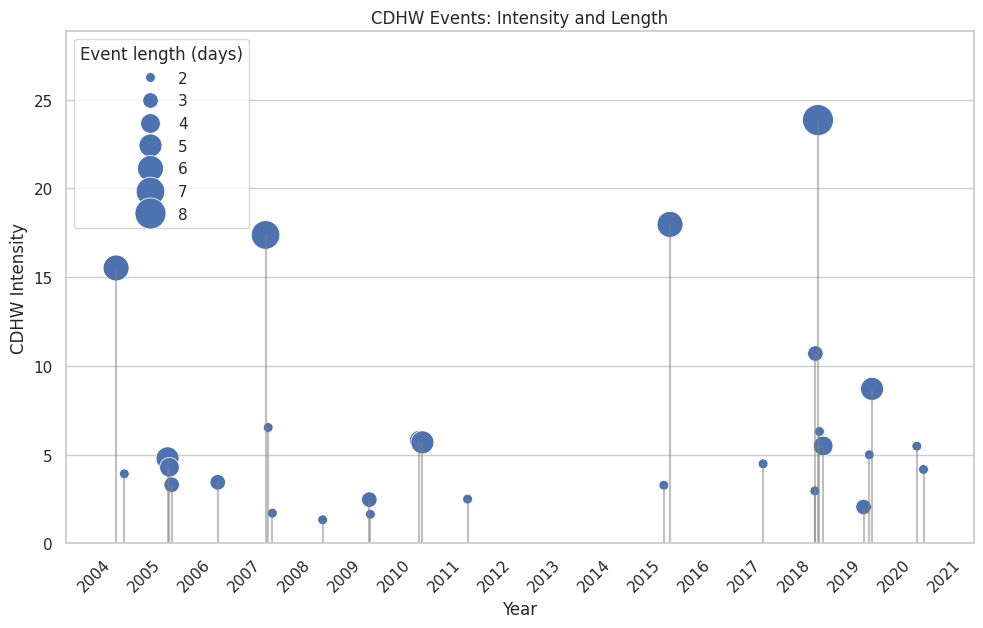

In [ ]:
csv_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/CDHWs/Beijing.csv'
cdhw_summary_df = pd.read_csv(csv_file_name)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

def plot_cdhw_events(cdhw_summary_df):
    sns.set_theme(style="whitegrid")

    # Convert start_date and end_date from string to datetime
    cdhw_summary_df['start_date'] = pd.to_datetime(cdhw_summary_df['start_date'])
    cdhw_summary_df['end_date'] = pd.to_datetime(cdhw_summary_df['end_date'])

    # Calculate the length of each CDHW event in days
    cdhw_summary_df['event_length'] = (cdhw_summary_df['end_date'] - cdhw_summary_df['start_date']).dt.days

    # Create a new figure for the seaborn plot
    plt.figure(figsize=(10, 6))

    # Plot vertical lines for each event duration
    plt.vlines(x=cdhw_summary_df['start_date'], ymin=0, ymax=cdhw_summary_df['cdhw_intensity'], color='grey', alpha=0.5)

    # Plot using seaborn: we'll use the start date for the x-axis, intensity for y-axis, and event length for dot size
    scatter = sns.scatterplot(data=cdhw_summary_df, x='start_date', y='cdhw_intensity',
                              size='event_length', legend=True, sizes=(50, 500))
    scatter.legend(title="Event length (days)")
    scatter.xaxis.grid(False)

    # Adjust x-axis limits based on the start and end dates of the events
    x_min = cdhw_summary_df['start_date'].min().replace(year=cdhw_summary_df['start_date'].min().year - 1)
    x_max = cdhw_summary_df['end_date'].max().replace(year=cdhw_summary_df['end_date'].max().year + 1)
    plt.xlim(x_min, x_max)

    # Adjusting the plot to make it more readable
    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.ylim(top=cdhw_summary_df['cdhw_intensity'].max()+5)
    plt.rcParams['axes.xmargin'] = 0.
    # plt.rcParams['axes.ymargin'] = 0.
    plt.xlabel('Year')
    plt.ylabel('CDHW Intensity')
    plt.title('CDHW Events: Intensity and Length')
    plt.xticks(rotation=45)

    # Return the figure for further use (like saving)
    fig = plt.gcf()
    return fig

# Example usage (assuming cdhw_summary_df is already loaded)
plt_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/figures/CDHWs Beijing.jpg'
plt = plot_cdhw_events(cdhw_summary_df)
plt.savefig(plt_file_name, dpi=200)
plt.show()

## Identify u-CDHWs and calculate intensities

### Define helper functions

This function aims to aggregate CDHW intensities for each city by ensuring the CDHW event occurs across all DVSN_Name with the intensity being the minimum recorded across these divisions.

In [ ]:
def aggregate_cdhw_intensities_logic(cdhw_intensities_by_dvsn):
    """
    Aggregates CDHW intensities across DVSN_Names for a city, keeping only those events that occur
    in all DVSN_Names and taking the minimum intensity across all DVSN_Names for each event.

    Parameters:
    - cdhw_intensities_by_dvsn (dict): A dictionary where keys are DVSN_Names and values are DataFrames
      containing CDHW intensities for those DVSN_Names.

    Returns:
    - DataFrame: Aggregated CDHW intensities for the city.
    """
    # Check if any item in cdhw_intensities_by_dvsn is empty
    if any(df.empty for df in cdhw_intensities_by_dvsn.values()):
        # Return an empty DataFrame if any DVSN_Name data is empty
        return pd.DataFrame()

    # Convert the dictionary of DataFrames into a list of DataFrames with a new column for DVSN_Name
    cdhw_dfs = []
    for dvsn_name, df in cdhw_intensities_by_dvsn.items():
        df['DVSN_Name'] = dvsn_name
        cdhw_dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    combined_df = pd.concat(cdhw_dfs)

    # Group by heatwave_id and filter to keep only those groups present in all DVSN_Names
    grouped = combined_df.groupby('heatwave_id')
    filtered_groups = [group for name, group in grouped if len(group['DVSN_Name'].unique()) == len(cdhw_intensities_by_dvsn)]

    # Combine the filtered groups back into a DataFrame
    filtered_df = pd.concat(filtered_groups)

    # Aggregate the intensities by taking the minimum cdhw_intensity for each heatwave_id
    # and also aggregate start_date and end_date
    aggregated_df = filtered_df.groupby('heatwave_id').agg({
        'cdhw_intensity': 'min',
        'start_date': 'min',
        'end_date': 'max'
    }).reset_index().rename(columns={'cdhw_intensity': 'u_cdhw_intensity'})

    # Aggregate the intensities by taking the minimum cdhw_intensity for each heatwave_id
    aggregated_df = filtered_df.groupby(['heatwave_id','start_date','end_date'])['cdhw_intensity'].min().reset_index(name='u_cdhw_intensity')

    return aggregated_df

### Apply to Chinese cities

In [ ]:
import geopandas as gpd
from tqdm import tqdm
import os

urban_water_cnt = gpd.read_file('/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/data/urban_water_source_connections.gpkg')

path_heatwaves = '/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/heatwaves'
path_water_volumes = '/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water volumes'
path_water_stats = '/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water stats'

path_uCDHWs = '/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/uCDHWs/'

# Iterate over each unique city
for city_name in tqdm(urban_water_cnt['Urban Agglomeration'].unique()):

    pd.options.mode.chained_assignment = None  # default='warn'

    # Output filename
    csv_file_name = f'{path_uCDHWs}/{city_name}.csv'
    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    # Load the heatwave intensity DataFrame for the city
    df_heatwave_intensity = pd.read_csv(f"{path_heatwaves}/{city_name}.csv")

    # Initialize a container to hold CDHW intensities for each DVSN_Name
    cdhw_intensities_by_dvsn = {}

    # Iterate over DVSN_Name for the current city
    for _, row in urban_water_cnt[urban_water_cnt['Urban Agglomeration'] == city_name].iterrows():
        dvsn_name = row['DVSN_Name'].replace('/','\\')
        if "Groundwater" in dvsn_name:
            continue  # Skip groundwater sources

        # Load water volumes and stats DataFrames
        water_volumes_df = pd.read_csv(f"{path_water_volumes}/{dvsn_name}.csv")
        water_stats_df = pd.read_csv(f"{path_water_stats}/{dvsn_name}.csv")

        # Calculate CDHW intensity (function definition and implementation required)
        cdhw_intensity = calculate_cdhw_intensity(df_heatwave_intensity, water_volumes_df, water_stats_df, "Surface water")

        # Store the calculated CDHW intensity by DVSN_Name
        cdhw_intensities_by_dvsn[dvsn_name] = cdhw_intensity

    # Aggregate CDHW intensities across all DVSN_Name (implementation of aggregation logic required)
    # This step would involve finding common CDHW events across DVSN_Names and selecting the minimum intensity.

    # Example placeholder for aggregated CDHW intensity calculation
    u_cdhw_intensity = aggregate_cdhw_intensities_logic(cdhw_intensities_by_dvsn)

    # Export the results
    u_cdhw_intensity.to_csv(csv_file_name)


100%|██████████| 18/18 [01:08<00:00,  3.81s/it]


### Apply to global cities

In [ ]:
import geopandas as gpd
from tqdm import tqdm
import os

urban_water_cnt = gpd.read_file('/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/data/McDonald GEC 2014/urban_water_source_connections.geojson')

path_heatwaves = '/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/heatwaves'
path_water_volumes = '/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water volumes'
path_water_stats = '/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/water stats'

path_uCDHWs = '/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/uCDHWs/'

# Iterate over each unique city
for city_name in tqdm(urban_water_cnt['Urban Agglomeration'].unique()):

    pd.options.mode.chained_assignment = None  # default='warn'

    # Output filename
    csv_file_name = f'{path_uCDHWs}/{city_name}.csv'
    # Check if the CSV file already exists
    if os.path.exists(csv_file_name):
        continue  # Skip this iteration if the file exists

    # Load the heatwave intensity DataFrame for the city
    csv_file_name = f"{path_heatwaves}/{city_name}.csv"
    # Skip this iteration if the file doesn't exists
    if (not os.path.exists(csv_file_name)):
        continue  # Skip this iteration if the file exists
    df_heatwave_intensity = pd.read_csv(csv_file_name)

    if len(df_heatwave_intensity)==0:
        continue

    # Initialize a container to hold CDHW intensities for each DVSN_Name
    cdhw_intensities_by_dvsn = {}

    # Iterate over DVSN_Name for the current city
    for _, row in urban_water_cnt[urban_water_cnt['Urban Agglomeration'] == city_name].iterrows():
        dvsn_name = row['DVSN_Name'].replace('/','\\')
        if "Groundwater" in dvsn_name:
            continue  # Skip groundwater sources

        # Load water volumes and stats DataFrames
        water_volumes_df = pd.read_csv(f"{path_water_volumes}/{dvsn_name}.csv")
        water_stats_df = pd.read_csv(f"{path_water_stats}/{dvsn_name}.csv")

        # Calculate CDHW intensity (function definition and implementation required)
        cdhw_intensity = calculate_cdhw_intensity(df_heatwave_intensity, water_volumes_df, water_stats_df, "Surface water")

        # Store the calculated CDHW intensity by DVSN_Name
        cdhw_intensities_by_dvsn[dvsn_name] = cdhw_intensity

    # Aggregate CDHW intensities across all DVSN_Name (implementation of aggregation logic required)
    # This step would involve finding common CDHW events across DVSN_Names and selecting the minimum intensity.

    if len(cdhw_intensities_by_dvsn)==0:
      continue

    # Example placeholder for aggregated CDHW intensity calculation
    u_cdhw_intensity = aggregate_cdhw_intensities_logic(cdhw_intensities_by_dvsn)

    # Export the results
    csv_file_name = f'{path_uCDHWs}/{city_name}.csv'
    u_cdhw_intensity.to_csv(csv_file_name)


,Unnamed: 0,heatwave_id,start_date,end_date,u_cdhw_intensity
0,0,2010-88,2010-08-30,2010-09-01,2.351930
1,1,2010-88,2010-08-30,2010-09-02,3.867733
2,2,2010-88,2010-09-01,2010-09-01,0.585007
3,3,2010-88,2010-09-02,2010-09-02,0.186374
4,4,2011-92,2011-07-14,2011-07-16,1.245519
5,5,2011-93,2011-07-18,2011-07-22,2.001002
6,6,2011-94,2011-07-25,2011-08-01,4.166873
7,7,2011-94,2011-07-25,2011-08-03,5.745691


## Visualize individual u-CDHWs

In [ ]:
# Re-import necessary libraries after the reset
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Corrected plotting function to accommodate both CDHW and uCDHW data
def plot_cdhw_and_ucdhw_events(cdhw_df, ucdhw_df):
    sns.set_theme(style="whitegrid")

    # Ensure start_date and end_date columns in both DataFrames are datetime objects
    cdhw_df['start_date'] = pd.to_datetime(cdhw_df['start_date'])
    cdhw_df['end_date'] = pd.to_datetime(cdhw_df['end_date'])
    ucdhw_df['start_date'] = pd.to_datetime(ucdhw_df['start_date'])
    ucdhw_df['end_date'] = pd.to_datetime(ucdhw_df['end_date'])

    # Calculate the length of each event in days
    cdhw_df['Event lengt (days)'] = (cdhw_df['end_date'] - cdhw_df['start_date']).dt.days
    ucdhw_df['Event lengt (days)'] = (ucdhw_df['end_date'] - ucdhw_df['start_date']).dt.days


    # Step 1: Rename the 'intensity' columns
    cdhw_df.rename(columns={'cdhw_intensity': 'intensity'}, inplace=True)
    ucdhw_df.rename(columns={'u_cdhw_intensity': 'intensity'}, inplace=True)

    # Step 2: Add 'event_type' column to indicate whether it's 'CDHW' or 'u-CDHW'
    cdhw_df['Event type'] = 'CDHW'
    ucdhw_df['Event type'] = 'u-CDHW'

    # Step 3: Concatenate cdhw_df and ucdhw_df together
    all_events_df = pd.concat([cdhw_df, ucdhw_df])
    all_events_df.rename(columns={'event_type': 'Event type'})

    # Step 4: Plot using Seaborn
    plt.figure(figsize=(12, 6))
    plt.vlines(x=all_events_df['start_date'], ymin=0, ymax=all_events_df['intensity'], color='grey', alpha=0.5)
    scatter = sns.scatterplot(data=all_events_df, x='start_date', y='intensity', size='Event lengt (days)',
                              hue='Event type', sizes=(50, 500), palette={'CDHW': 'blue', 'u-CDHW': 'red'})
    scatter.xaxis.grid(False)

    # Adjust x-axis limits based on the start and end dates of the events
    x_min = all_events_df['start_date'].min().replace(year=all_events_df['start_date'].min().year - 1)
    x_max = all_events_df['end_date'].max().replace(year=all_events_df['end_date'].max().year + 1)
    plt.xlim(x_min, x_max)

    # Adjusting the plot
    plt.ylim(top=all_events_df['intensity'].max()+5)
    plt.rcParams['axes.xmargin'] = 0.
    plt.tight_layout()
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Year')
    plt.ylabel('Intensity')
    plt.title('CDHW vs. u-CDHW Events: Intensity and Dates')
    plt.xticks(rotation=45)

    return plt


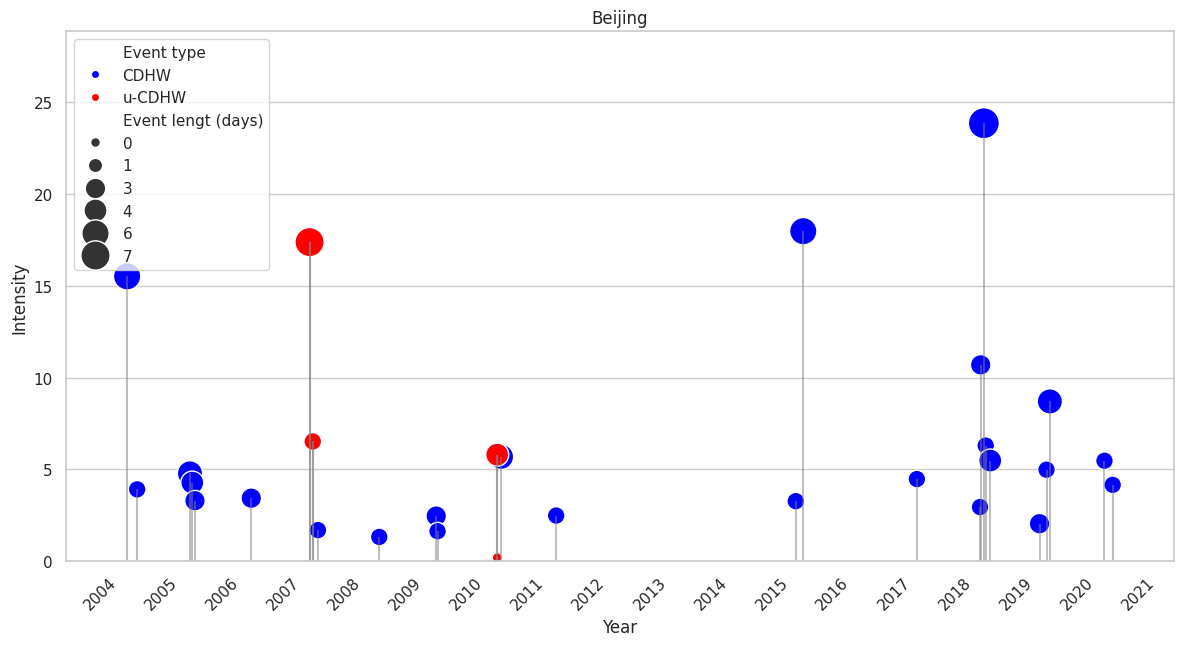

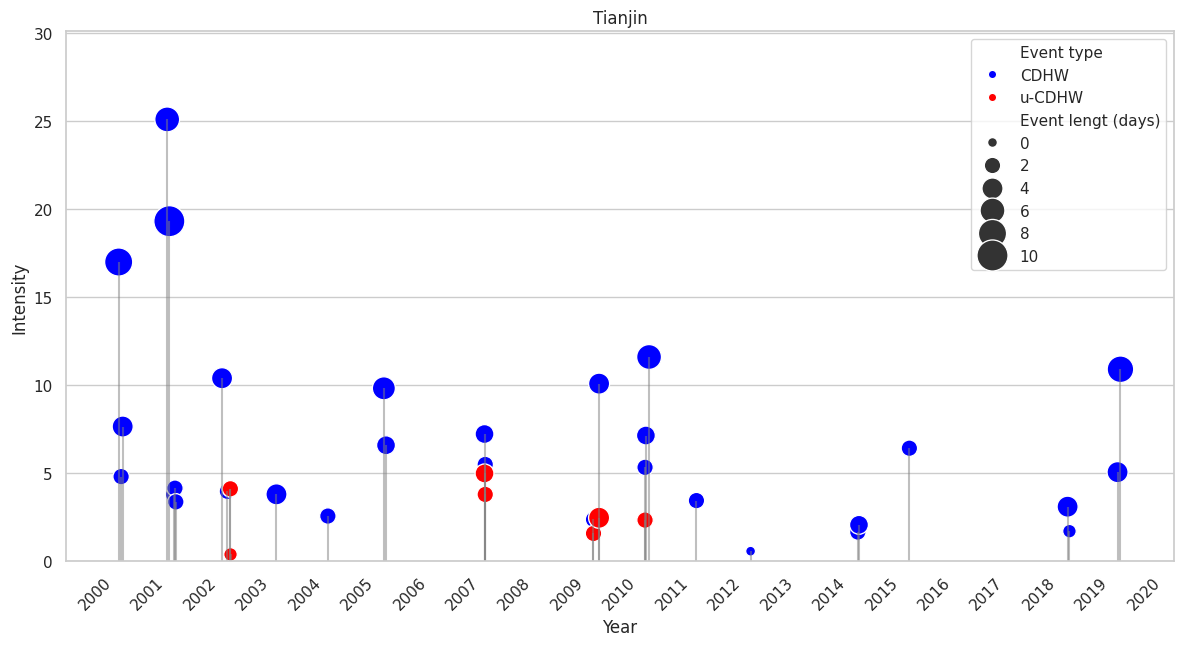

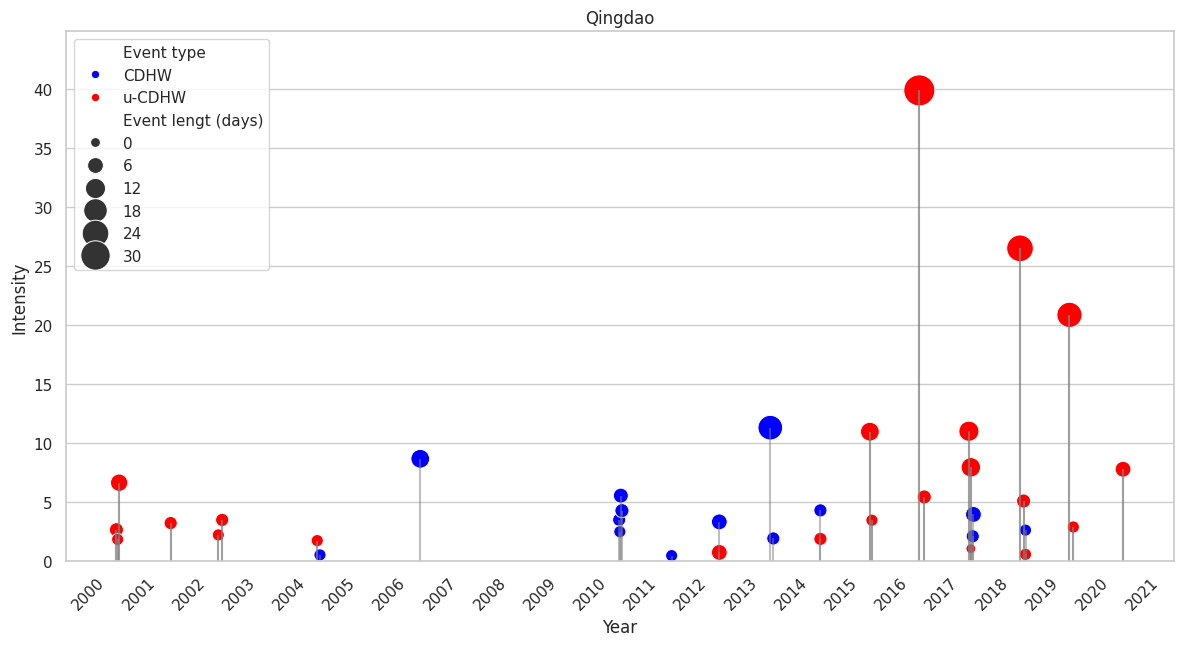

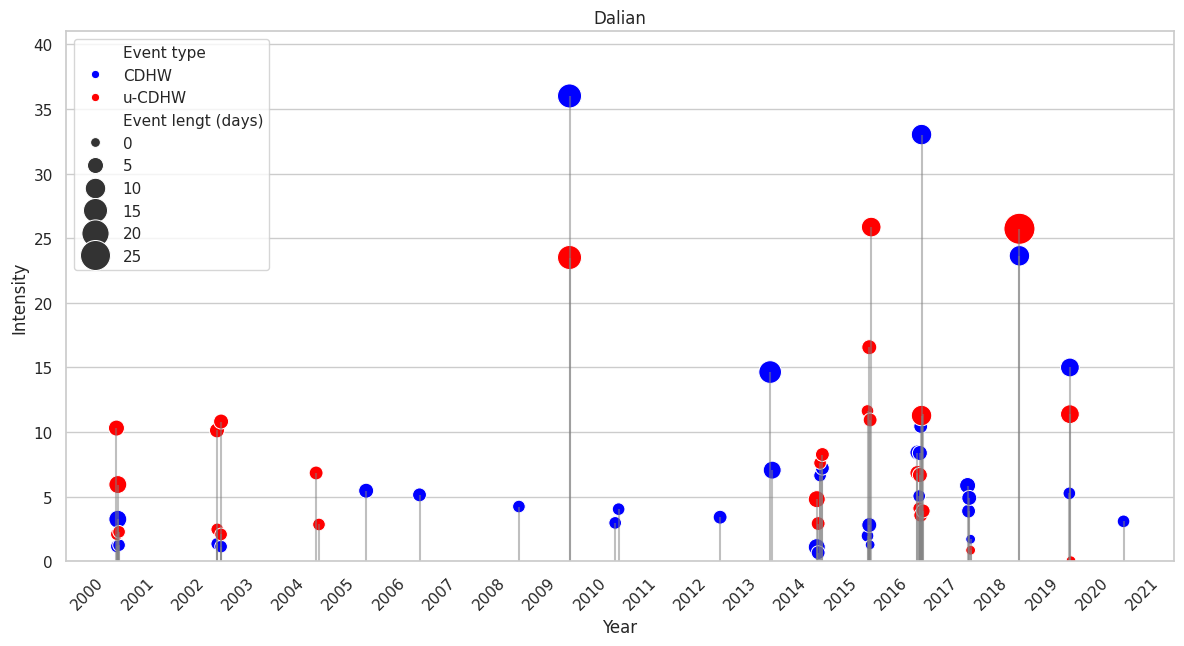

In [ ]:
path_uCDHWs = '/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/uCDHWs/'
path_CDHWs = '/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/results/CDHWs/'

def export_plot_city_uCDHWs(city_name):
  cdhw_df = pd.read_csv(f'{path_CDHWs}/{city_name}.csv')
  ucdhw_df = pd.read_csv(f'{path_uCDHWs}/{city_name}.csv')

  plt_file_name = f'/content/drive/MyDrive/Grants_Fellowship/2023 Amazon Research Awards/figures/uCDHWs {city_name}.jpg'
  fig = plot_cdhw_and_ucdhw_events(cdhw_df, ucdhw_df)
  fig.title(city_name)
  fig.subplots_adjust(top=1)
  fig.savefig(plt_file_name, dpi=200, bbox_inches='tight')


export_plot_city_uCDHWs('Beijing')
export_plot_city_uCDHWs('Tianjin')
export_plot_city_uCDHWs('Qingdao')
export_plot_city_uCDHWs('Dalian')